In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../scripts")
import models
import pickle
from Bio import SeqIO
from main import *

In [16]:
data = load_data("../data/GM12878_10k", "../data/loop_sequences_GM12878.fasta", "../data/epigenomic_tracks/GM12878.pickle", test=True)
seq_length = 100
spacing = 50
Rs = [initial_pairwise_interactions(data, 2, seq_length, spacing)]

Reading histone data...
Reading sequence data...
Reading Hi-C data...
Sequence object not found for sequence 10:49865000:50015000
Sequence object not found for sequence 10:50620000:50725000
Sequence object not found for sequence 10:52190000:52270000
Sequence object not found for sequence 10:54070000:54250000
Sequence object not found for sequence 10:54400000:54550000
Sequence object not found for sequence 10:54405000:54485000
Sequence object not found for sequence 10:5485000:5625000
Sequence object not found for sequence 10:5485000:5670000
Sequence object not found for sequence 10:56850000:57030000
Sequence object not found for sequence 10:59945000:60050000
Sequence object not found for sequence 10:6055000:6130000
Sequence object not found for sequence 10:60710000:61005000
Sequence object not found for sequence 10:60710000:60940000
Sequence object not found for sequence 10:61385000:61570000
Sequence object not found for sequence 10:6150000:6245000
Sequence object not found for sequence

In [17]:
print("Initial:", Rs[-1])
rnn, R = train_iteration(data, Rs[-1], batch_size=20, seq_length=seq_length, spacing=spacing, old_rnn=None)

Initial: [[7 3]
 [3 6]]
(71760, 9, 100)
10:11555000:11805000
10:101190000:101480000
10:103050000:103210000
10:27530000:27650000
Prediction composition: (array([None], dtype=object), array([1]))
10:134035000:134165000
10:101190000:101375000
10:104590000:104830000
10:30705000:30825000
10:26895000:27175000
10:15470000:15770000
10:124100000:124195000
10:124055000:124195000
10:103600000:103775000
10:11555000:11770000
10:38140000:38390000
10:103360000:103545000
10:121505000:121620000
10:2970000:3090000
10:102430000:102505000
10:102970000:103205000
(71760, 9, 100) (71760, 2)
Epoch 1/10
56824/56824 [==============================] - 11s 192us/step - loss: 0.6908 - acc: 0.5148
Epoch 2/10
56824/56824 [==============================] - 9s 161us/step - loss: 0.6886 - acc: 0.5255
Epoch 3/10
56824/56824 [==============================] - 9s 155us/step - loss: 0.6863 - acc: 0.5261
Epoch 4/10
56824/56824 [==============================] - 9s 154us/step - loss: 0.6847 - acc: 0.5287
Epoch 5/10
56824/568

In [18]:
R

array([[5.44793615, 5.32009448],
       [5.32010487, 5.2520964 ]])

In [91]:
from update_state_assignments import *

R = np.array([[7, 3], [3, 6]])
n_labels = R.shape[0]

# Generate a random batch of data
indexes = np.random.choice(len(data), size=(5,), replace=False)
batch = [data[i] for i in indexes]
X, ranges = generate_X(batch, seq_length=seq_length, spacing=spacing)

print(X.shape)
# Run DP algorithm
coarse_spacing = spacing * 10
Y_single = np.zeros((X.shape[0],), dtype=int) # Each element corresponds to one row of X
# Vectors corresponding to states for each interaction matrix
rnn_iter = (None for _ in ranges)
S_mats = []
B_mats = []

for i, (_, H) in enumerate(batch):
    print(H.identifier)
    S, B, state_labels = state_asg(H, R, normalized_diff, penalty, coarse_spacing, None, return_matrices=True)
    S_mats.append(S)
    B_mats.append(B)
    # Save the state labels that begin after the first seq_length region
    trimmed = interpolate_state_labels(state_labels, coarse_spacing, spacing)[seq_length // spacing:]

    start, stop = ranges[i]
    #TODO: Don't allow these cases to pass
    if trimmed.shape[0] < stop - start:
        print("Too big:", trimmed.shape[0], start, stop, stop - start)
        continue
    # Store predicted state labels in Y vector
    Y_single[start:stop] = trimmed[:stop - start]

(18590, 9, 100)
10:103985000:104240000
10:120325000:120480000
10:43850000:43955000
10:49570000:49865000
10:129510000:129655000


In [86]:
def simulate_H(states, R):
    n_states = R.shape[0]
    result = np.zeros((len(states), len(states)))
    #states_1, states_2 = np.meshgrid(states, states)
    for i in range(len(states)):
        for j in range(len(states)):
            result[i,j] = R[states[i],states[j]]
    return result

In [95]:
reals = []
sims = []
for i, (start, stop) in enumerate(ranges):
    print(i)
    reals.append(batch[i][1].values_grid(spacing))
    sims.append(simulate_H(Y_single[start:stop], R))

0
1
2
3
4


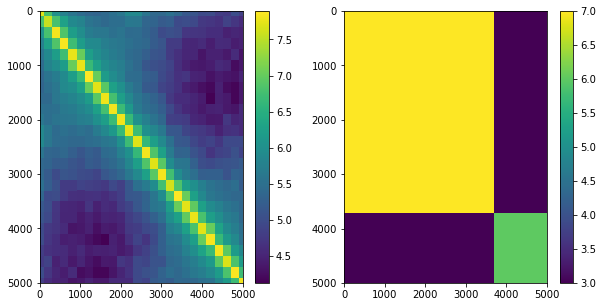

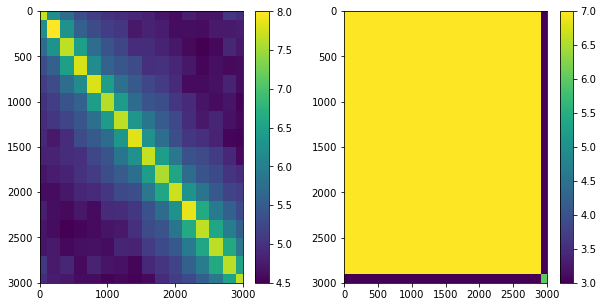

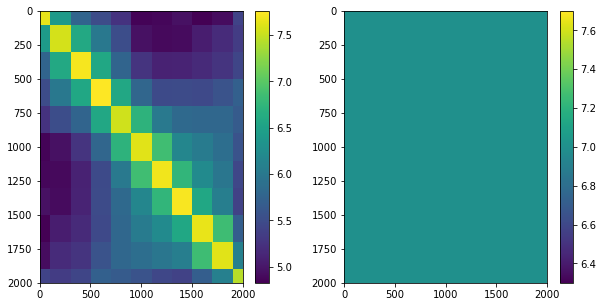

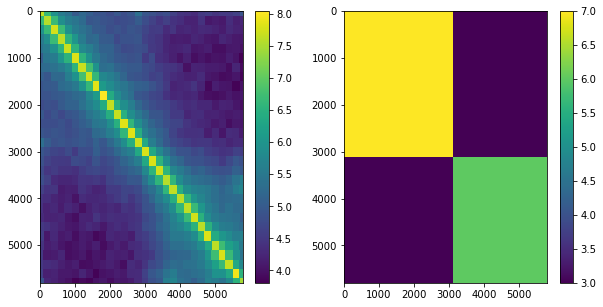

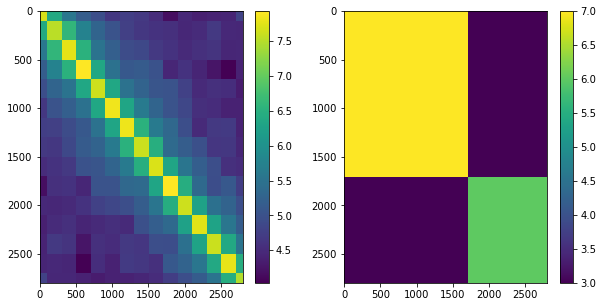

In [96]:
for i, (real, sim) in enumerate(zip(reals, sims)):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(real, aspect='auto')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(sim, aspect='auto')
    plt.colorbar()
    plt.show()

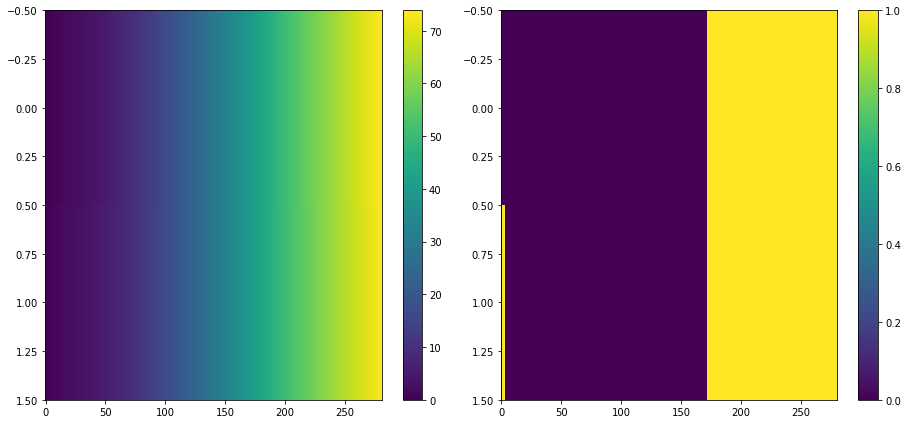

In [94]:
idx = 4
S = S_mats[idx]
B = B_mats[idx]
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plt.imshow(S, aspect='auto')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(B, aspect='auto')
plt.colorbar()
plt.tight_layout()
plt.show()

In [18]:
def initial_pairwise_interactions(data, n_labels, batch_size=10, bound=0.25):
    """
    Generates an random initial R matrix of dimension n_labels x n_labels given
    the data.

    data: a list of tuples (Sequence, InteractionMatrix) as generated from
        load_data.
    batch_size: the number of elements of data to select randomly to use in this
        iteration.
    """
    def shear_matrix(ssm):
        # Each column shifts one more down
        new_ssm = np.zeros(ssm.shape)
        for n in range(ssm.shape[0]):
            new_ssm[:,n] = np.roll(ssm[:,n], -n)
        return new_ssm

    batch_H = [shear_matrix(np.log(1+data[i][1].values_grid())) for i in range(batch_size)]
#     for mat in batch_H:
#         plt.figure()
#         plt.imshow(mat)
#         plt.show()
    diagonal_avg = 0.0
    off_diagonal_avg = 0.0
    for i in range(len(batch_H)):
        H = batch_H[i]
        bound_len = int(bound*H.shape[0])
        diagonal_avg += np.average(np.concatenate((H[:bound_len//2,:], H[H.shape[0] - bound_len//2:,:])))
        off_diagonal_avg += np.average(H[bound_len//2:H.shape[0] - bound_len//2,:])

    diagonal_avg /= len(batch_H)
    off_diagonal_avg /= len(batch_H)
    
    print(diagonal_avg / off_diagonal_avg)

    R = np.full((n_labels,n_labels), off_diagonal_avg, dtype=float)
    np.fill_diagonal(R, diagonal_avg)
    return R

In [20]:
for bound in np.arange(0.05, 1, 0.05):
    R = initial_pairwise_interactions(data, 2, bound=bound)
    print(R)

/Users/venkatesh-sivaraman/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/venkatesh-sivaraman/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
[[       nan 5.52943126]
 [5.52943126        nan]]
nan
[[       nan 5.43993836]
 [5.43993836        nan]]
nan
[[       nan 5.39029437]
 [5.39029437        nan]]
nan
[[       nan 5.28012317]
 [5.28012317        nan]]
1.2902209771457926
[[6.72706748 5.21388785]
 [5.21388785 6.72706748]]
1.2726230011378619
[[6.59841997 5.18489762]
 [5.18489762 6.59841997]]
1.2580453129125446
[[6.48898954 5.15799349]
 [5.15799349 6.48898954]]
1.2356388360118833
[[6.30773322 5.10483568]
 [5.10483568 6.30773322]]
1.2267191964936566
[[6.24212095 5.08846765]
 [5.08846765 6.24212095]]
1.2095510584059312
[[6.10833397 5.0500836 ]
 [5.0500836  6.10833397]]
1.201031255547186
[[6.04713474 5.03495201]
 [5.03495201 6.04713474]]
1.1852304342248627
[[5.93370688 5.00637404]
 [5.00637404 5.93370688]]
1.1795232781716718
[[5.8941918  4.99709663]
 [4.99709663 5.8941918 ]]
1.1731560383024697
[[5.85175456 4.98804453]
 [4.98804453 5.85175456]]
1.1608854186108943
[[5.77138721 4.97153907]
 [4.97153907 5.77138721]]
1.150185101